In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [3]:
# url = 'https://bnonews.com/index.php/2020/02/the-latest-coronavirus-cases/'
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR30F8lYP3jG7YOq8es0PBpJIE5yvRVZffOyaqC0GgMBN6yt0Q-NI8pxS7hd1F9dYXnowSC6zpZmW9D/pubhtml'
driver.get(url)
content = driver.page_source


### Extract date time

In [4]:
# soup =BeautifulSoup(content, 'lxml')

In [5]:
# data = soup.findAll(text=re.compile("Last update: .+"))
# data

In [6]:
# m = re.search("Last update: (\d+ \w+ 202\d) at (\d+:\d+ [apAP].*[mM])", data[0])
# data_date_time = ' '.join([m.group(1), m.group(2)])
# data_date_time = re.sub("[\.]","",data_date_time)
# data_date_time = datetime.strptime(data_date_time, '%d %B %Y %I:%M %p').strftime('%Y-%m-%d %H:%M')
# data_date_time
data_date_time = datetime.now().strftime('%Y-%m-%d %H:%M')
data_date_time

'2020-03-29 20:09'

### Dataframes

In [7]:

dfs = pd.read_html(content)

In [8]:
len(dfs)
dfs[0]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1.0,Currently being updated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,CASES,DEATHS,RECOVERED,RECOVERED,UNRESOLVED,UNRESOLVED,UNRESOLVED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,715212,33583,155811,155811,525818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,198.0,Papua New Guinea,1,0,0,0,0.00%,NaN,0,Source,NaN,NaN,1,0,NaN,NaN,NaN
199,199.0,Saint Vincent and the Grenadines,1,0,0,0,0.00%,NaN,NaN,Source,NaN,NaN,1,0,NaN,NaN,NaN
200,200.0,TBD,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5568.0,65.0
201,201.0,TOTAL,715212,47586,33583,2699,4.70%,24824,155811,NaN,NaN,NaN,662058,30819,NaN,NaN,NaN


### International

In [9]:
df_intl=dfs[0]
df_intl  = df_intl.drop(df_intl .columns[0], axis=1)
df_intl  = df_intl.drop(list(range(6)), axis=0)
num_cols = len(df_intl.columns)
columns = ['d'] * num_cols
columns[0]='international'
columns[1]='cases'
df_intl.columns=columns
df_intl



,international,cases,d,d,d,d,d,d,d,d,d,d,d,d,d,d
6,WORLD,Cases,New cases,Deaths,New deaths,Death rate,Serious & Critical,Recovered,Links,NaN,NaN,Cases,Deaths,NaN,NaN,NaN
7,United States,136492,12604,2400,179,1.76%,2576,4047,Source,NaN,NaN,123888,2221,NaN,NaN,NaN
8,Italy,97689,5217,10779,756,11.03%,3906,13030,Source,NaN,NaN,92472,10023,NaN,NaN,NaN
9,China,81439,45,3300,5,4.05%,742,75448,Source,NaN,NaN,81394,3295,NaN,NaN,NaN
10,Spain,78799,5567,6606,624,8.38%,4907,14709,Source,NaN,NaN,73232,5982,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Papua New Guinea,1,0,0,0,0.00%,NaN,0,Source,NaN,NaN,1,0,NaN,NaN,NaN
199,Saint Vincent and the Grenadines,1,0,0,0,0.00%,NaN,NaN,Source,NaN,NaN,1,0,NaN,NaN,NaN
200,TBD,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5568.0,65.0
201,TOTAL,715212,47586,33583,2699,4.70%,24824,155811,NaN,NaN,NaN,662058,30819,NaN,NaN,NaN


In [10]:
df_intl.columns = df_intl.columns.map(str.lower)
df_intl = df_intl.dropna(0, how='all')

#### Cases

In [11]:
df_intl_cases = df_intl[['international', 'cases']].set_index('international').T
df_intl_cases.drop(columns = ['China', 'TOTAL', 'TBD'], inplace=True)
df_intl_cases


international,WORLD,United States,Italy,Spain,Germany,Iran,France,United Kingdom,Switzerland,Netherlands,...,British Virgin Islands,Guinea-Bissau,Somalia,Turks and Caicos Islands,Belize,Timor-Leste,Libya,Papua New Guinea,Saint Vincent and the Grenadines,NaN
cases,Cases,136492,97689,78799,60739,38309,40174,19522,14799,10866,...,2,2,2,2,2,1,1,1,1,Cases


In [12]:
na_columns = df_intl_cases.columns[df_intl_cases.columns.isna()]
df_intl_cases.drop(columns=na_columns, inplace=True)

In [13]:
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [re.sub('[^\d]+', '', x)  for x in row ])
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [int(x) if x!='' else 0  for x in row ])

In [14]:
df_intl_cases

international,WORLD,United States,Italy,Spain,Germany,Iran,France,United Kingdom,Switzerland,Netherlands,...,St. Kitts and Nevis,British Virgin Islands,Guinea-Bissau,Somalia,Turks and Caicos Islands,Belize,Timor-Leste,Libya,Papua New Guinea,Saint Vincent and the Grenadines
cases,0,136492,97689,78799,60739,38309,40174,19522,14799,10866,...,2,2,2,2,2,2,1,1,1,1


In [15]:
# add date time column
df_intl_cases.insert(0, 'datetime', data_date_time)
df_intl_cases

international,datetime,WORLD,United States,Italy,Spain,Germany,Iran,France,United Kingdom,Switzerland,...,St. Kitts and Nevis,British Virgin Islands,Guinea-Bissau,Somalia,Turks and Caicos Islands,Belize,Timor-Leste,Libya,Papua New Guinea,Saint Vincent and the Grenadines
cases,2020-03-29 20:09,0,136492,97689,78799,60739,38309,40174,19522,14799,...,2,2,2,2,2,2,1,1,1,1


In [16]:
# some assertion to ensure data quality
assert int(df_intl_cases['South Korea'])>6000

#### Save to file

In [17]:
from pathlib import Path
csv_file = '../data/bnonews-international.csv'

df = df_intl_cases

if Path(csv_file).exists():
    old_df = pd.read_csv(csv_file, parse_dates=True)



In [18]:
# unnamed_cols = old_df.columns[old_df.columns.str.startswith('Unnamed')]
# old_df.drop(columns=unnamed_cols, inplace=True)

In [19]:
df = pd.concat([old_df, df], sort=True)
df = df.set_index('datetime').fillna(0)

In [20]:

df = df.loc[~df.index.duplicated(keep='first')]
df.sort_values(by=['datetime'], inplace=True)


for col in df.columns:
    df[col] = df[col].astype('int')
    
df

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Vatican City,Venezuela,Vietnam,WORLD,Zambia,Zimbabwe
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-06 08:03,0,0,0,0,0,0,0,0,0,15,...,2,12,0,0,0,0,12,0,0,0
2020-02-06 08:19,0,0,0,0,0,0,0,0,0,15,...,3,12,0,0,0,0,12,0,0,0
2020-02-06 09:01,0,0,0,0,0,0,0,0,0,15,...,3,12,0,0,0,0,12,0,0,0
2020-02-06 09:46,0,0,0,0,0,0,0,0,0,15,...,3,12,0,0,0,0,12,0,0,0
2020-02-06 17:56,0,0,0,0,0,0,0,0,0,15,...,3,12,0,0,0,0,12,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-29 16:08,110,174,454,308,3,7,745,329,46,3980,...,19522,126436,274,133,4,113,179,0,16,7
2020-03-29 17:08,110,174,454,308,3,7,745,329,46,3980,...,19522,131676,274,133,4,113,179,0,16,7
2020-03-29 18:09,110,174,454,308,3,7,745,329,46,3980,...,19522,132821,274,133,4,113,179,0,16,7


In [21]:

df.to_csv(csv_file, index=True)


Text(0.5, 0, 'Number of cases, sampled at 2020-03-29 20:09')

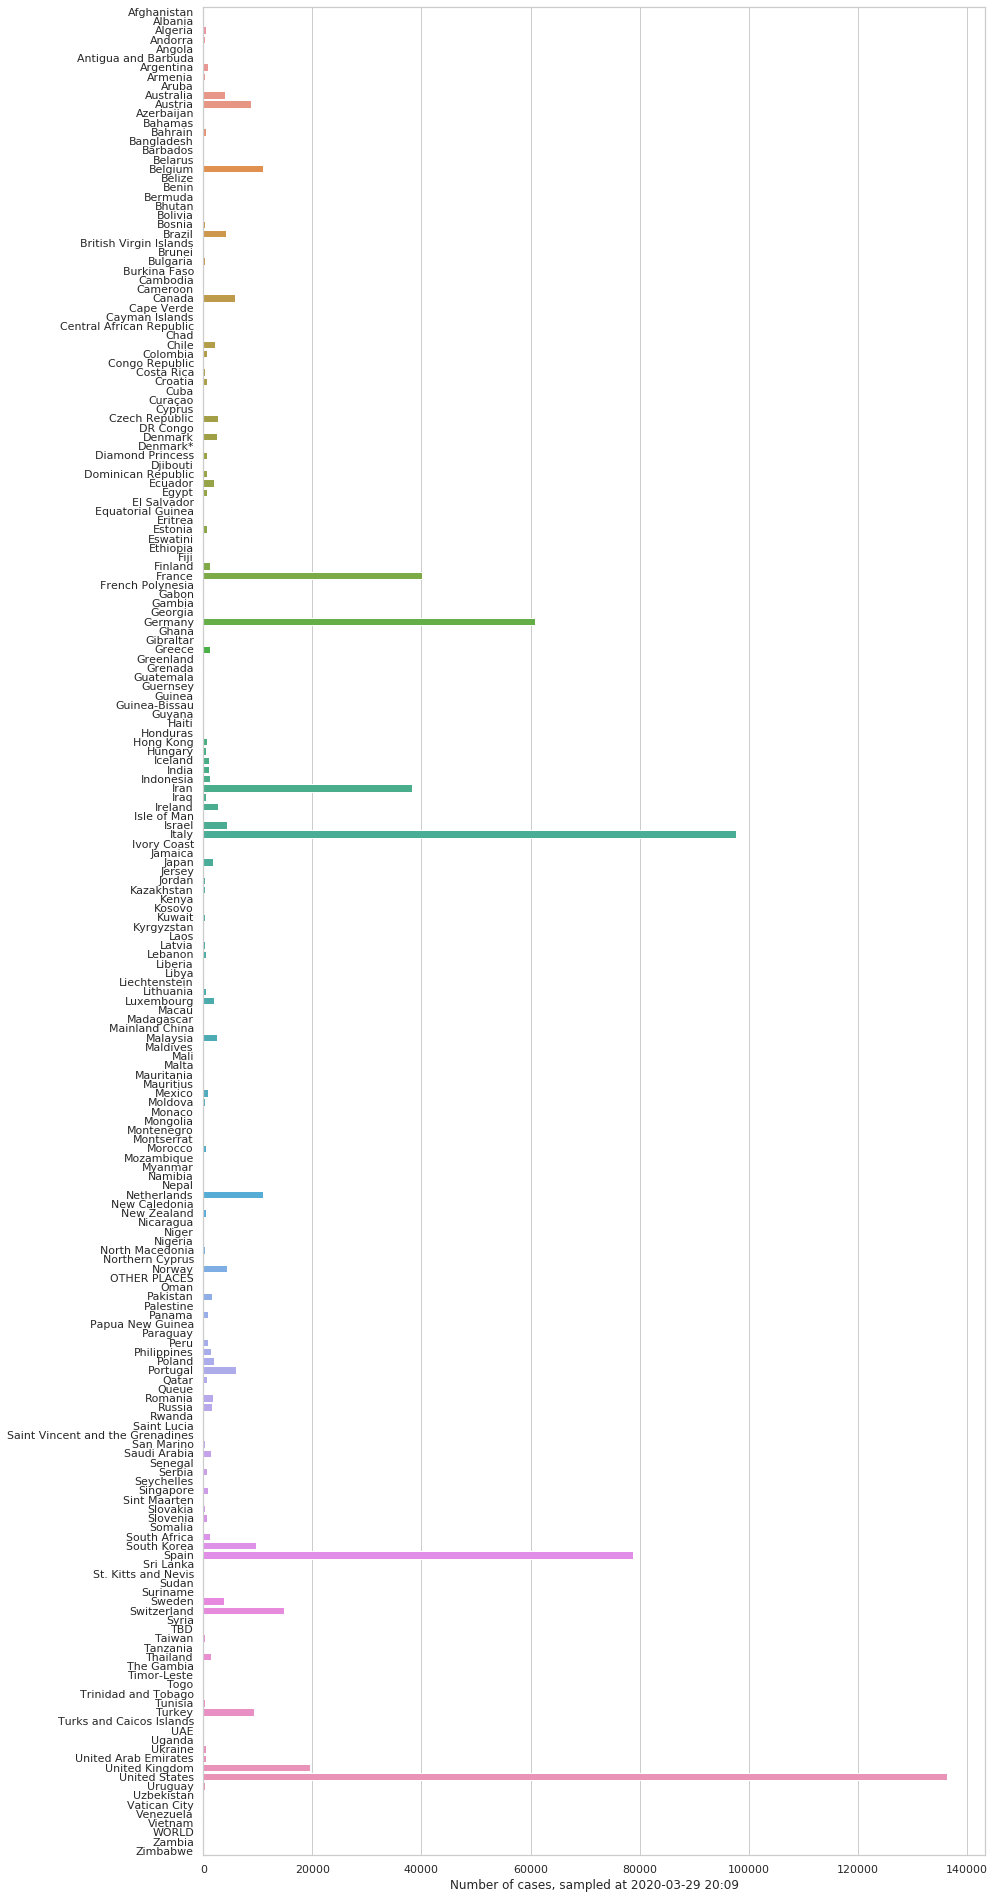

In [22]:
import seaborn as sns

series = df.iloc[-1]

sns.set(rc={'figure.figsize':(14,34)})
sns.set(style="whitegrid")

ax = sns.barplot(y=series.index, x=series)
ax.set_xlabel('Number of cases, sampled at '+series.name)


In [23]:
png_file='../images/bnonews-international.png'
fig = ax.get_figure()
fig.savefig(png_file)